In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# load a bird, get its songs from some day

In [6]:
from data.dataset import bird_dataset_single_hdf

In [7]:
dataset = bird_dataset_single_hdf('/home/songbird/datapartition/all_birds.hdf', 'r15y5')

... total number of folders for bird r15y5 = 41 ...


In [8]:
# choose a day
X = dataset.get(day=18, nsamps=-1)

In [9]:
len(X)

2906

# Compare the mean squared error performance of the learned PCA model and the autoencoder

In [36]:
from utils.utils import load_netG, load_netE, overlap_encode, overlap_decode
from reconstruction_error.pca import reconstruction, split_song_sequence

In [10]:
netG = load_netG('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz16_alldaysnets_ngf64/netG_epoch_60_day_all.pth', nz=16, ngf=64,
                 cuda=True, resnet=True)

In [11]:
netE = load_netE('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz16_alldaysnets_ngf64/netE_epoch_60_day_all.pth', nz=16, ngf=64,
                 cuda=True, resnet=True)

In [43]:
# encode
Z = [overlap_encode(x, netE) for x in X]
# decode
Xhat = [overlap_decode(z, netG)[0] for z in Z]

In [15]:
len(Xhat)

2906

load pca model

In [19]:
from sklearn.decomposition import PCA

In [18]:
pca_model = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz16_alldaysnets_ngf64/pca_model.pkl')

In [21]:
pca_model = pca_model['pca_model']

<BarContainer object of 2064 artists>

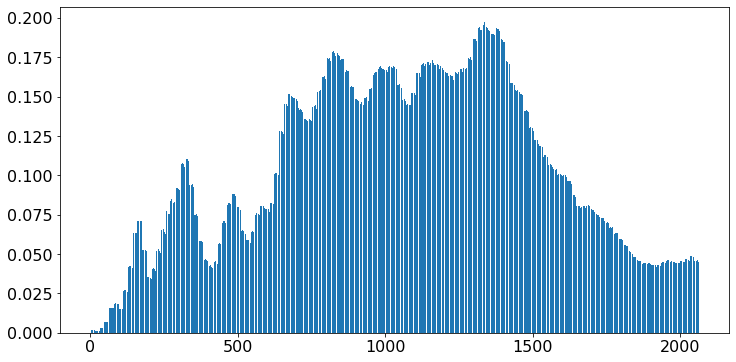

In [26]:
plt.figure(figsize=(12,6))
plt.bar(np.arange(pca_model.mean_.shape[0]), pca_model.mean_)

In [22]:
pca_model.n_components_

837

In [62]:
from copy import deepcopy

In [76]:
pca_short = deepcopy(pca_model)

In [77]:
pca_short.components_ = pca_short.components_[:16,:]

In [40]:
Xhat_pca = reconstruction(X, pca_model)

In [78]:
Xhat_low_pca = reconstruction(X, pca_short)

In [51]:
def make_vectors(Y):
    Yout = []
    for seq in Y:
        ychunks = split_song_sequence(seq, 16)
        ychunks = np.concatenate([y.flatten().reshape(1,-1) for y in ychunks])
        Yout.append(ychunks)
    return np.concatenate(Yout)

In [52]:
Xorig = make_vectors(X)
Xorig.shape

(61557, 2064)

In [53]:
Xhat = make_vectors(Xhat)
Xhat.shape

(61557, 2064)

In [54]:
Xhat_pca = make_vectors(Xhat_pca)
Xhat_pca.shape

(61557, 2064)

In [79]:
Xhat_low_pca = make_vectors(Xhat_low_pca)
Xhat_low_pca.shape

(61557, 2064)

In [80]:
L2_gan = ((Xorig - Xhat)**2).sum(axis=1).mean()
L2_pca = ((Xorig - Xhat_pca)**2).sum(axis=1).mean()
L2_low_pca = ((Xorig - Xhat_low_pca)**2).sum(axis=1).mean()

In [81]:
print(L2_gan, L2_pca, L2_low_pca)

11.003618778022323 0.746384519632184 11.12211384467365


In [83]:
L1_gan = (np.abs(Xorig - Xhat)).sum(axis=1).mean()
L1_pca = (np.abs(Xorig - Xhat_pca)).sum(axis=1).mean()
L1_low_pca = (np.abs(Xorig - Xhat_low_pca)).sum(axis=1).mean()

In [84]:
print(L1_gan, L1_pca, L1_low_pca)

66.7223660434071 22.125343334637336 84.62787285447922
